In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir('/content/drive/MyDrive/WirelessMLCodes/CEL_SS/2023SPRVersion')

In [2]:
'''Energydetection, updated Mar2023
'''
import torch
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
import math
import torchvision
import torchvision.transforms as transforms
import torch.utils.data.distributed as TUDdistributed
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
import sys
from copy import deepcopy
import random
import collections
#from MobileNetV1_CriticalPath import Net
import matplotlib.pyplot as plt
import pandas as pd 
# from sklearn.externals import joblib
from cnn_models import standalone_cnn
from cnn_models import decouple_cnn
from cnn_models import decouple_cnn_mod

from pytz import timezone
TMZ = timezone('EST')
import datetime
import shutil
import time

device = torch.device("cuda")
# if os.environ["CUDA_VISIBLE_DEVICES"]:
#     device = torch.device("cuda")
# else:
#     device = torch.device("cpu")

# device = torch.device("cpu")
use_cuda = True
criterion = nn.CrossEntropyLoss()

random.seed(0) 

      

def Dis_analysis(class_dir, tol_list):
  #idx_list: list of lists, global positions of locally observable bands for each node
  #coef_list: coef for averaging the param for each band, how many nodes are learning each certain band
    idx_list = []
    coef_list = [0]*len( tol_list )
    for i in range( len(class_dir) ): #Generating the mapping btw nodes and net_tol
        sub_idx_list = [] 
        for j in class_dir[i]:
            for k in range( len(tol_list) ):
                if j == tol_list[k]:
                    sub_idx_list.append(k)
                    coef_list[k] += 1 
                    break
        idx_list.append(sub_idx_list)
    return idx_list, coef_list


"""626/720 dataset maker, each logit corresponds to the occupation of a single channel"""
class TotalDatasetMaker(Dataset):
    "simple version that requires the user to edit input/label format elsewhere"
    def __init__(self, db, label_list, transformFunc ):
        """
        db: a list of input signal tensors, label_list: a list of data labels, corresponding to db.
        """
        self.datasets = db
        self.label_list = label_list
        self.transformFunc = transformFunc
    def __getitem__(self, i):
        img = self.datasets[i]
        img = self.transformFunc(img)
        class_label = self.label_list[i]
        return img, class_label

    def __len__(self):
        return len(self.label_list)
    
    
"""720 dataset maker, data looks like: each global channel occupation condition ==> 
each node only learn from 'local' received signal(full size for each node) which is an element in the list of this condition """
class NodeDatasetMaker(Dataset):

    def __init__(self, db, label_list, node, class_dir, transformFunc ):
        """
        db: a list of input signal tensors, label_list: a list of data labels, corresponding to db.
        node
        """
        self.datasets = db
        self.label_list = label_list
        self.transformFunc = transformFunc
        self.chn_list = class_dir[node]
        self.node = node
    def __getitem__(self, i):
        img = self.datasets[i][self.node]
        img = self.transformFunc(img)
        class_label = self.label_list[i][self.chn_list]
        return img, class_label

    def __len__(self):
        return len(self.label_list)

def setDir(filepath):
  # if directory not exist, create. if directory already exist, empty it.
  if not os.path.exists(filepath):
    os.makedirs(filepath)
  else:
    print('Directory already exists')
    shutil.rmtree(filepath, ignore_errors = True)
    os.mkdir(filepath)
       
print('start')

start


/tmp/ipykernel_1879126/2000592684.py:22: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# '''2023 Spr version, for energy detection'''
def energy_detection_coop(thresh_list, class_dir, coef_list, test_loader):                             
#     '''Tests all nodes together, use TotalDatasetMaker, smarter distrib energy detection'''
#     '''thresh_list is the thresh for diff nodes, by default they're the same'''
    total = 0 #sum of occupation and emptiness
    test_loss = 0 
    total_ocp = 0 #occupied bands
    total_emp = 0 #empty bands
    correct = 0
    total_cmb = 0  #occupation combination
    correct_ocp = 0
    correct_emp = 0
    correct_cmb = 0
    coef = torch.tensor(coef_list)

    for batchidx, (data, target) in enumerate(test_loader):
        #data, target = data.cuda(), target.cuda()
        #print(target.size())
#             data, target = Variable(data), Variable(target)
        target = Variable(target)
#             print('target size is:',target.size())
        output_manual = torch.zeros(target.shape) # manual global decision of CNN
        total_batch = float(torch.tensor(target.size()).prod()) #total num of channels in this batch
        total += total_batch
        total_cmb += float(target.size(0))
        total_ocp += float(target.sum())
        total_emp += float(total_batch - target.sum()) 
        if (1-target).sum() != (torch.tensor(target.size()).prod() - target.sum()) : #Testing tensor dim =========
            print('show difference:',(1-target).sum(), total - target.sum())
            print('total ocp/emp calculation wrong')
        '''Above calculate the total number of channels detected and the ground truth number of occupation/emptiness'''

        for idx in range(len(class_dir)): # apply fusion strategy on local detections
            node_power = torch.sum(1e7*data[idx], dim = -2)#  # get (batchsize*2) tensors of local channel power
            if idx == -1:
                print(node_power)
            localout = (node_power[:,0,class_dir[idx]]>thresh_list[idx]).float()
            output_manual[:,class_dir[idx]] = output_manual[:,class_dir[idx]].add(localout) 
            # strategy: any node detects means occupation

        output_manual = (output_manual.div_(coef) >0.49)
        correct_ocp += (output_manual*target).sum()
        correct_emp += ((~output_manual)*(1-target)).sum()
        correct_cmb += (~(output_manual^target.bool())).float().prod(1).sum() #use XNOR which is 'not+XOR'
#         print('correctocp',correct_ocp)

    correct_tol = deepcopy(correct_ocp) + deepcopy(correct_emp) #just sum
    accuracy_tol = 100*correct_tol/total
    accuracy_pd = 100*correct_ocp/total_ocp
    accuracy_pfa = 100*correct_emp/total_emp
    accuracy_cmb = 100*correct_cmb/total_cmb

#     print('++++++++++++++++++ Accuracy on global set: total: %d %%, combination: %d %%, PD: %d %%, PFA: %d %%' \
#                                             % ( accuracy_tol, accuracy_cmb, accuracy_pd, 100-accuracy_pfa))
    Acc_set = (accuracy_tol.item(), accuracy_cmb.item(), accuracy_pd.item(), 100-accuracy_pfa.item())
    return Acc_set

# '''2023 Spr version, for energy detection'''
def energy_detection_coopSQR(thresh_list, class_dir, coef_list, test_loader):  
# squared input PSD                           
#     '''Tests all nodes together, use TotalDatasetMaker, smarter distrib energy detection'''
#     '''thresh_list is the thresh for diff nodes, by default they're the same'''
    total = 0 #sum of occupation and emptiness
    test_loss = 0 
    total_ocp = 0 #occupied bands
    total_emp = 0 #empty bands
    correct = 0
    total_cmb = 0  #occupation combination
    correct_ocp = 0
    correct_emp = 0
    correct_cmb = 0
    coef = torch.tensor(coef_list)
    for batchidx, (data, target) in enumerate(test_loader):
        #data, target = data.cuda(), target.cuda()
        #print(target.size())
#             data, target = Variable(data), Variable(target)
        target = Variable(target)
#             print('target size is:',target.size())
        output_manual = torch.zeros(target.shape) # manual global decision of CNN
        total_batch = float(torch.tensor(target.size()).prod()) #total num of channels in this batch
        total += total_batch
        total_cmb += float(target.size(0))
        total_ocp += float(target.sum())
        total_emp += float(total_batch - target.sum()) 
        if (1-target).sum() != (torch.tensor(target.size()).prod() - target.sum()) : #Testing tensor dim =========
            print('show difference:',(1-target).sum(), total - target.sum())
            print('total ocp/emp calculation wrong')
        '''Above calculate the total number of channels detected and the ground truth number of occupation/emptiness'''
        for idx in range(len(class_dir)): # apply fusion strategy on local detections
            node_power = torch.sum((1e7*data[idx])**2, dim = -2)#  # get (batchsize*2) tensors of local channel power
            if idx == -1:
                print(node_power)
            localout = (node_power[:,0,class_dir[idx]]>thresh_list[idx]).float()
            output_manual[:,class_dir[idx]] = output_manual[:,class_dir[idx]].add(localout) 
            # strategy: any node detects means occupation
        output_manual = (output_manual.div_(coef) >0.49)
        correct_ocp += (output_manual*target).sum()
        correct_emp += ((~output_manual)*(1-target)).sum()
        correct_cmb += (~(output_manual^target.bool())).float().prod(1).sum() #use XNOR which is 'not+XOR'
#         print('correctocp',correct_ocp)
    correct_tol = deepcopy(correct_ocp) + deepcopy(correct_emp) #just sum
    accuracy_tol = 100*correct_tol/total
    accuracy_pd = 100*correct_ocp/total_ocp
    accuracy_pfa = 100*correct_emp/total_emp
    accuracy_cmb = 100*correct_cmb/total_cmb
#     print('++++++++++++++++++ Accuracy on global set: total: %d %%, combination: %d %%, PD: %d %%, PFA: %d %%' \                                          % ( accuracy_tol, accuracy_cmb, accuracy_pd, 100-accuracy_pfa))
    Acc_set = (accuracy_tol.item(), accuracy_cmb.item(), accuracy_pd.item(), 100-accuracy_pfa.item())
    return Acc_set

def ROC_thresh(start, end, pts):
    return [start+i*(end-start)/pts for i in range(100)]

thresh_dict = {
    0: ROC_thresh(10, 30 ,100),
    -2: ROC_thresh(15, 40 ,100),
    -4: ROC_thresh(20, 50 ,100),
    -6: ROC_thresh(40, 80 ,100),
    -8: ROC_thresh(70, 120 ,100),
    -10: ROC_thresh(100, 200 ,100),
    -12: ROC_thresh(170, 300 ,100),
    -14: ROC_thresh(300, 460 ,100),
    -16: ROC_thresh(450, 700 ,100),
    -18: ROC_thresh(450, 700 ,100),
}


gain_dif:  23.47391270072688
[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]] [2, 3, 2, 2, 6, 6, 2, 2, 3, 2, 3, 2, 2, 6, 2, 2, 3, 2, 2, 6]
model watermark 240208_01_06
Models saved to dir:
 Saved_Models/EnergyDetect/Alpha5//SNRs/-4dBVol20_240208_01_06/
thresh: 20.0 accuracy: 50.0 PD: 100.0 PFA: 100.0
thresh: 20.3 accuracy: 50.0 PD: 100.0 PFA: 100.0
thresh: 20.6 accuracy: 50.0 PD: 100.0 PFA: 100.0
thresh: 20.9 accuracy: 50.0 PD: 100.0 PFA: 100.0
thresh: 21.2 accuracy: 50.0 PD: 100.0 PFA: 100.0
thresh: 21.5 accur

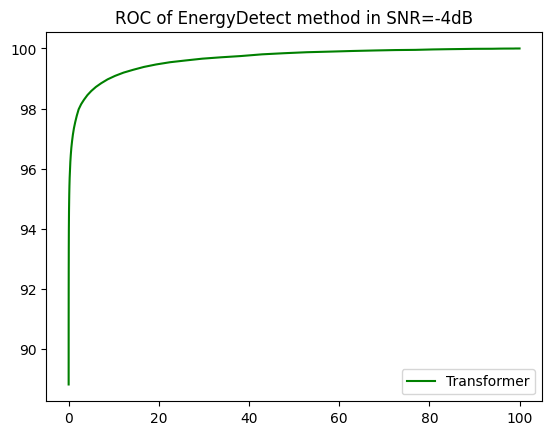

ROC in Excel saved to: Saved_Models/EnergyDetect/Alpha5//SNRs/-4dBVol20_240208_01_06/ROC_SNR-4.xlsx
ROC in Lists saved to: Saved_Models/EnergyDetect/Alpha5//SNRs/-4dBVol20_240208_01_06/EnergyDetectROC.pth
gain_dif:  23.47391270072688
[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]] [2, 3, 2, 2, 6, 6, 2, 2, 3, 2, 3, 2, 2, 6, 2, 2, 3, 2, 2, 6]
model watermark 240208_01_07
Models saved to dir:
 Saved_Models/EnergyDetect/Alpha5//SNRs/-6dBVol20_240208_01_07/
thresh: 40.0 accuracy: 50.00048828125 PD: 100.0 PFA: 99.99

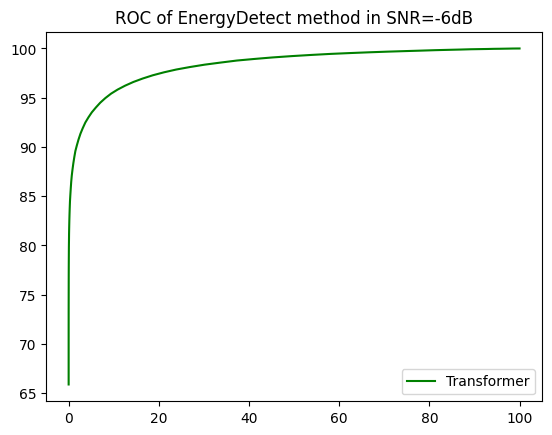

ROC in Excel saved to: Saved_Models/EnergyDetect/Alpha5//SNRs/-6dBVol20_240208_01_07/ROC_SNR-6.xlsx
ROC in Lists saved to: Saved_Models/EnergyDetect/Alpha5//SNRs/-6dBVol20_240208_01_07/EnergyDetectROC.pth
gain_dif:  23.47391270072688
[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]] [2, 3, 2, 2, 6, 6, 2, 2, 3, 2, 3, 2, 2, 6, 2, 2, 3, 2, 2, 6]
model watermark 240208_01_08
Models saved to dir:
 Saved_Models/EnergyDetect/Alpha5//SNRs/-8dBVol20_240208_01_08/
thresh: 70.0 accuracy: 50.07275390625 PD: 99.99853515625 P

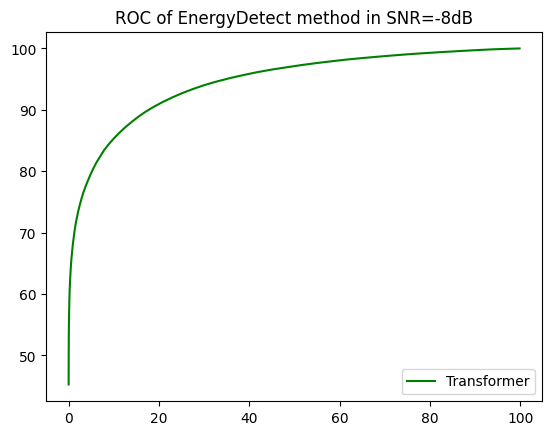

ROC in Excel saved to: Saved_Models/EnergyDetect/Alpha5//SNRs/-8dBVol20_240208_01_08/ROC_SNR-8.xlsx
ROC in Lists saved to: Saved_Models/EnergyDetect/Alpha5//SNRs/-8dBVol20_240208_01_08/EnergyDetectROC.pth
gain_dif:  23.47391270072688
[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]] [2, 3, 2, 2, 6, 6, 2, 2, 3, 2, 3, 2, 2, 6, 2, 2, 3, 2, 2, 6]
model watermark 240208_01_09
Models saved to dir:
 Saved_Models/EnergyDetect/Alpha5//SNRs/-10dBVol20_240208_01_09/
thresh: 100.0 accuracy: 50.0 PD: 100.0 PFA: 100.0
thresh:

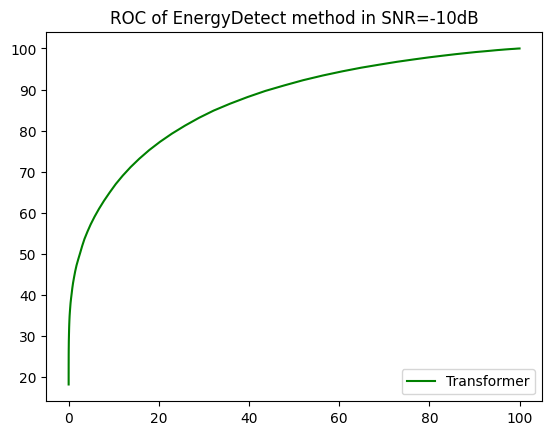

ROC in Excel saved to: Saved_Models/EnergyDetect/Alpha5//SNRs/-10dBVol20_240208_01_09/ROC_SNR-10.xlsx
ROC in Lists saved to: Saved_Models/EnergyDetect/Alpha5//SNRs/-10dBVol20_240208_01_09/EnergyDetectROC.pth
gain_dif:  23.47391270072688
[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]] [2, 3, 2, 2, 6, 6, 2, 2, 3, 2, 3, 2, 2, 6, 2, 2, 3, 2, 2, 6]
model watermark 240208_01_10
Models saved to dir:
 Saved_Models/EnergyDetect/Alpha5//SNRs/-12dBVol20_240208_01_10/
thresh: 170.0 accuracy: 50.010986328125 PD: 99.9990234

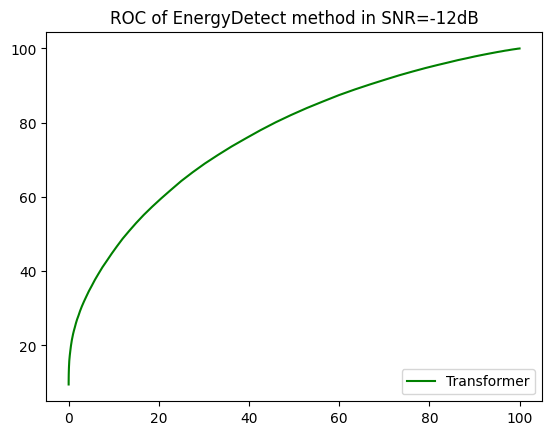

ROC in Excel saved to: Saved_Models/EnergyDetect/Alpha5//SNRs/-12dBVol20_240208_01_10/ROC_SNR-12.xlsx
ROC in Lists saved to: Saved_Models/EnergyDetect/Alpha5//SNRs/-12dBVol20_240208_01_10/EnergyDetectROC.pth
gain_dif:  23.47391270072688
[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]] [2, 3, 2, 2, 6, 6, 2, 2, 3, 2, 3, 2, 2, 6, 2, 2, 3, 2, 2, 6]
model watermark 240208_01_12
Models saved to dir:
 Saved_Models/EnergyDetect/Alpha5//SNRs/-14dBVol20_240208_01_12/
thresh: 300.0 accuracy: 50.703125 PD: 99.31494140625 P

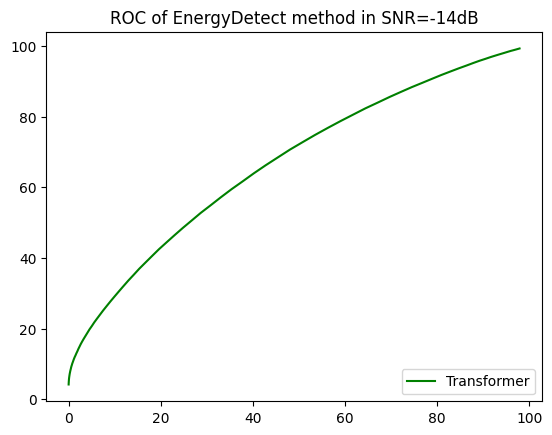

ROC in Excel saved to: Saved_Models/EnergyDetect/Alpha5//SNRs/-14dBVol20_240208_01_12/ROC_SNR-14.xlsx
ROC in Lists saved to: Saved_Models/EnergyDetect/Alpha5//SNRs/-14dBVol20_240208_01_12/EnergyDetectROC.pth
gain_dif:  23.47391270072688
[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]] [2, 3, 2, 2, 6, 6, 2, 2, 3, 2, 3, 2, 2, 6, 2, 2, 3, 2, 2, 6]
model watermark 240208_01_13
Models saved to dir:
 Saved_Models/EnergyDetect/Alpha5//SNRs/-16dBVol20_240208_01_13/
thresh: 450.0 accuracy: 50.092041015625 PD: 99.8759765

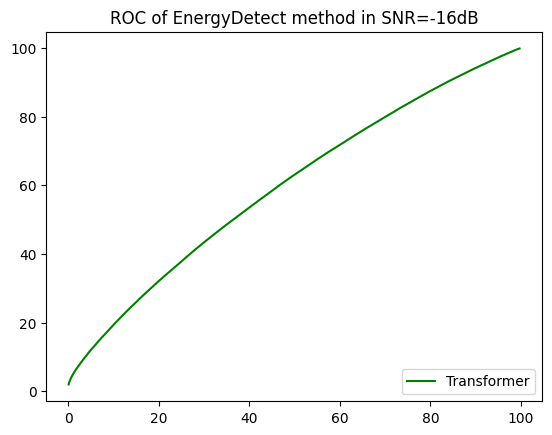

ROC in Excel saved to: Saved_Models/EnergyDetect/Alpha5//SNRs/-16dBVol20_240208_01_13/ROC_SNR-16.xlsx
ROC in Lists saved to: Saved_Models/EnergyDetect/Alpha5//SNRs/-16dBVol20_240208_01_13/EnergyDetectROC.pth


In [6]:
# for snr in [12, 8 ]: #[12, 8, 14, 16, 20]: #[12, 8 ]: #[12, 8, 14, 16, 20] #[0,2,4,6,8,10,12,14,16]
for snr in [4,6,8,10,12,14,16]: #[2,4,6,8,10,12,14,16]: #[12, 8 ]: #[12, 8, 14, 16, 20]
    roc_dots = 100
    volum = 20
    SNR= -1*snr 
    nepoch = 100
    stage_dir='/SNRs/'#for naming and directory
    DistAmp_tr = 10 # DistAmp = 10 #25
    DistAmp_te = 10
    alpha_tr = 3.71
    alpha_te = 5
    # datadir = 'RefinedNewData/demodata/230303_23_13Data_SNR-50vol1.pth' #10bands demo
    # datadir = 'RefinedNewData/demodata/230329_01_52Data_SNR0vol10.pth'
    # datadir = 'RefinedNewData/SNRs/230401_04_00/Data_SNR-8vol10.pth'
    # datadir = 'RefinedNewData/SNRs/230401_04_00/Data_SNR'+str(SNR)+'vol'+str(volum)+'.pth'
    datadir = 'RefinedNewData/SNRs/230404_01_04/Data_SNR'+str(SNR)+'vol'+str(volum)+'.pth'
    # datadir = 'RefinedNewData/SNRs/FullObs/Data_SNR'+str(SNR)+'vol'+str(volum)+'.pth'

    gain_dif= (DistAmp_te*2*3**0.5 /3)**alpha_te / (DistAmp_tr*2*3**0.5 /3)**alpha_tr
    print('gain_dif: ', gain_dif) # Seems not useful. The previous thresh_dict works
    datadir = 'RefinedNewData/SNRs/'+str(DistAmp_te)+'m_Alpha5/Data_SNR'+str(SNR)+'vol'+str(volum)+'.pth'

    data_dict = torch.load(datadir)
    data_dict.keys()

    db = data_dict['training data list']
    label_list = data_dict['training label list']
    db_te = data_dict['testing data list']
    label_list_te = data_dict['testing label list']
    db_te = data_dict['training data list']
    label_list_te = data_dict['training label list']

    # Create models ==================================================================================================
    per_class_filter = 8
    #fms = 16 #size of final conv feature map
    shared_layers = 1
    class_dir=[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]]
    # class_dir = [ list( range(20) ) for i in range(10)] # every local is Full_Observa

    tol_list = []
    for classi in class_dir:
        tol_list += classi
    tol_list = list( set(tol_list) )
    tol_list.sort()

    print(class_dir)
    print(tol_list)

    # get coef 
    idx_list, coef_list = Dis_analysis(class_dir, tol_list)
    print(idx_list, coef_list)


    db_tr_list = []
    for idx in range(len(class_dir)):# train datasets are more complex
        db_tr_list.append(NodeDatasetMaker( db, label_list, idx, class_dir, transforms.Compose([ ]) ))
    db_te_1 = TotalDatasetMaker( db_te, label_list_te, transforms.Compose([ ]) )

    train_loader_list = []
    for idx in range(len(class_dir)):# trainloaders are more complex
        train_loader_list.append(DataLoader(db_tr_list[idx], batch_size=200, shuffle=True, num_workers=4, pin_memory=True))
    # tol_train_loader = DataLoader(tol_trainsets, batch_size=100, shuffle=False, num_workers=0, pin_memory=True)
    tol_test_loader = DataLoader(db_te_1, batch_size=1024, shuffle=False, num_workers=4, pin_memory=True)

    now=datetime.datetime.now(TMZ) #time watermark
    time_watermark = now.strftime('%y%m%d_%H_%M')
    print('model watermark',time_watermark)
    address_model = 'Saved_Models/EnergyDetect/Alpha5/'+stage_dir+str(SNR)+'dBVol'+str(volum)+'_'+time_watermark+'/' #root dir for saved models
    #child dir nbamed by time_watermark
    setDir(address_model)
   
    print('Models saved to dir:\n', address_model)
    name0 = 'EnergyDetect'+'_SNR'+str(SNR)+'vol'+str(volum) # common part of DNN node names


    # ROC  ==================================================================================================
    '''ROC module of current standalone model, saved in pd2 and pfa2'''
    # net_list = Split_MDLT(net_list, net_tol, idx_list, coef_list,  shared_layers, class_dir) # if merged net better, do this before ROC
    pd2= []
    pfa2 = []
    Acc2 = []

    for thresh_val in thresh_dict[SNR]:  
      #[i*0.9999/100 for i in list(range(1,100))]
      # in [(1-i/50)*5e-8+1e-10 for i in list(range(50))]
        
        # CNNoutput = testnets(net_list, class_dir, tol_test_loader, thresh_sig=thresh_val) #
        # thresh_list = [thresh_val/gain_dif]*len(class_dir)
        thresh_list = [thresh_val]*len(class_dir)
        testing=energy_detection_coop(thresh_list, class_dir, coef_list, tol_test_loader)
        print('thresh:', thresh_list[0], 'accuracy:',testing[0], 'PD:',testing[2], 'PFA:',testing[3])
        # print('thresh:', thresh_val, 'accuracy:',testing[0], 'PD:',testing[2], 'PFA:',testing[3])

        pd2.append(testing[2])
        pfa2.append(testing[3])
        Acc2.append(testing[0])

    plt.title("ROC of EnergyDetect"+ " method in SNR="+str(SNR)+"dB")
    l2, = plt.plot(pfa2, pd2, color='green', label='Transformer')
    plt.legend(loc='lower right')
    plt.show()

    dfroc = pd.DataFrame() # save statics to excel
    # df1['acc_old'] = xx
    dfroc['PFA'] = pfa2
    dfroc['PD'] = pd2
    dfroc['Acc'] = Acc2
    with pd.ExcelWriter(address_model + "ROC_SNR"+str(SNR)+".xlsx", mode='w') as writer:  #mode was 'a'
      dfroc.to_excel(writer, sheet_name='EnergyDetect')
    print('ROC in Excel saved to:', address_model + "ROC_SNR"+str(SNR)+".xlsx")

    ROC_dict = {
        'pd':pd2,
        'pfa':pfa2,
        'Acc':Acc2
    }
    torch.save(ROC_dict, address_model+'EnergyDetect'+'ROC.pth')
    print('ROC in Lists saved to:', address_model+'EnergyDetect'+'ROC.pth')


In [5]:
#To shutdown workspace
from google.colab import runtime
runtime.unassign()

ModuleNotFoundError: No module named 'google'

In [ ]:
    # Quickly setup for testing Energy detection
    roc_dots = 100
    volum = 10
    SNR= -12
 
    stage_dir='/SNRs/'#for naming and directory
    # datadir = 'RefinedNewData/demodata/230303_23_13Data_SNR-50vol1.pth' #10bands demo
    # datadir = 'RefinedNewData/demodata/230329_01_52Data_SNR0vol10.pth'
    # datadir = 'RefinedNewData/SNRs/230401_04_00/Data_SNR-8vol10.pth'
    # datadir = 'RefinedNewData/SNRs/230401_04_00/Data_SNR'+str(SNR)+'vol'+str(volum)+'.pth'
    datadir = 'RefinedNewData/SNRs/230404_01_04/Data_SNR'+str(SNR)+'vol'+str(volum)+'.pth'

    data_dict = torch.load(datadir)
    data_dict.keys()

    db = data_dict['training data list']
    label_list = data_dict['training label list']
    db_te = data_dict['testing data list']
    label_list_te = data_dict['testing label list']

    # Create models ==================================================================================================
    per_class_filter = 8
    #fms = 16 #size of final conv feature map
    shared_layers = 1
    class_dir=[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]]

    tol_list = []
    for classi in class_dir:
        tol_list += classi
    tol_list = list( set(tol_list) )
    tol_list.sort()

    print(class_dir)
    print(tol_list)

    # get coef 
    idx_list, coef_list = Dis_analysis(class_dir, tol_list)
    print(idx_list, coef_list)


    db_tr_list = []
    for idx in range(len(class_dir)):# train datasets are more complex
        db_tr_list.append(NodeDatasetMaker( db, label_list, idx, class_dir, transforms.Compose([ ]) ))
    db_te_1 = TotalDatasetMaker( db_te, label_list_te, transforms.Compose([ ]) )

    train_loader_list = []
    for idx in range(len(class_dir)):# trainloaders are more complex
        train_loader_list.append(DataLoader(db_tr_list[idx], batch_size=200, shuffle=True, num_workers=4, pin_memory=True))
    # tol_train_loader = DataLoader(tol_trainsets, batch_size=100, shuffle=False, num_workers=0, pin_memory=True)
    tol_test_loader = DataLoader(db_te_1, batch_size=1024, shuffle=False, num_workers=4, pin_memory=True)

    now=datetime.datetime.now(TMZ) #time watermark
    time_watermark = now.strftime('%y%m%d_%H_%M')
    print('model watermark',time_watermark)
    # address_model = 'Saved_Models/EnergyDetect'+stage_dir+str(SNR)+'dBVol'+str(volum)+'_'+time_watermark+'/' #root dir for saved models
    # #child dir nbamed by time_watermark
    # setDir(address_model+'checkpoint/') # if dir not exist, create. if dir already exist, empty it.
    # setDir(address_model+'bestmodel/')

'''Finding proper threshold values for ROC'''
#===test energy detect
#SNR=0, [10, 18,19,20,30]: 99.7%  ok
#snr = -2  [15, 25, 27, 28, 29, 30, 40]:  99.49%  ok
#snr = -4  [20, 35, 40,41, 42, 43,44, 45, 50 ] 97.96% ok
#snr = -6  [40, 55, 61, 62, 63, 64, 65, 70, 80] 94.12%  ok
#snr = -8  [70, 80, 90, 100, 97, 110, 120]: 89%  ok
#snr = -10  [100,  130, 145, 147, 150, 155, 200] 78.5% ok
#snr = -12  [ 200, 210, 220, 225, 229,230,231, 235, 240, 300,]: 69.3% ok
#snr = -14  [ 300, 350, 355, 360, 370, 460]: 62.08%  ok
#snr = -16  [450, 550, 555, 560, 563, 575, 600,700]: 56.6%  ok
#snr = -18  [ 700,800,850, 900,950,1000, 1200] no need to plot
for thresh_val in [150, 170, 180, 200, 210, 220, 225 ]: 
    thresh_list = [thresh_val]*len(class_dir)
    testing=energy_detection_coop(thresh_list, class_dir, coef_list, tol_test_loader)
    print('thresh:', thresh_val, 'accuracy:',testing[0], 'PD:',testing[2], 'PFA:',testing[3])
# for thresh_val in [ 140, 150, 160, 170,180, 190, 200, 220, 225, 230, 235]:
#     thresh_list = [thresh_val]*len(class_dir)
#     testingSQ=energy_detection_coopSQR(thresh_list, class_dir, coef_list, tol_test_loader)
#     print('accuracySQR:',testingSQ[0], 'PD:',testingSQ[2], 'PFA:',testingSQ[3])
   



[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]] [2, 3, 2, 2, 6, 6, 2, 2, 3, 2, 3, 2, 2, 6, 2, 2, 3, 2, 2, 6]
model watermark 230421_20_08


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


thresh: 150 accuracy: 50.0 PD: 100.0 PFA: 100.0
thresh: 170 accuracy: 50.0048828125 PD: 99.990234375 PFA: 99.98046875
thresh: 180 accuracy: 50.09765625 PD: 99.9609375 PFA: 99.765625
thresh: 200 accuracy: 53.4716796875 PD: 97.568359375 PFA: 90.625
thresh: 210 accuracy: 60.439453125 PD: 91.62109375 PFA: 70.7421875
thresh: 220 accuracy: 66.62109375 PD: 78.603515625 PFA: 45.361328125
thresh: 225 accuracy: 68.69140625 PD: 70.263671875 PFA: 32.880859375


In [ ]:
print(thresh_dict[-8])
print(thresh_dict[-14])

[70.0, 70.5, 71.0, 71.5, 72.0, 72.5, 73.0, 73.5, 74.0, 74.5, 75.0, 75.5, 76.0, 76.5, 77.0, 77.5, 78.0, 78.5, 79.0, 79.5, 80.0, 80.5, 81.0, 81.5, 82.0, 82.5, 83.0, 83.5, 84.0, 84.5, 85.0, 85.5, 86.0, 86.5, 87.0, 87.5, 88.0, 88.5, 89.0, 89.5, 90.0, 90.5, 91.0, 91.5, 92.0, 92.5, 93.0, 93.5, 94.0, 94.5, 95.0, 95.5, 96.0, 96.5, 97.0, 97.5, 98.0, 98.5, 99.0, 99.5, 100.0, 100.5, 101.0, 101.5, 102.0, 102.5, 103.0, 103.5, 104.0, 104.5, 105.0, 105.5, 106.0, 106.5, 107.0, 107.5, 108.0, 108.5, 109.0, 109.5, 110.0, 110.5, 111.0, 111.5, 112.0, 112.5, 113.0, 113.5, 114.0, 114.5, 115.0, 115.5, 116.0, 116.5, 117.0, 117.5, 118.0, 118.5, 119.0, 119.5]
[300.0, 301.6, 303.2, 304.8, 306.4, 308.0, 309.6, 311.2, 312.8, 314.4, 316.0, 317.6, 319.2, 320.8, 322.4, 324.0, 325.6, 327.2, 328.8, 330.4, 332.0, 333.6, 335.2, 336.8, 338.4, 340.0, 341.6, 343.2, 344.8, 346.4, 348.0, 349.6, 351.2, 352.8, 354.4, 356.0, 357.6, 359.2, 360.8, 362.4, 364.0, 365.6, 367.2, 368.8, 370.4, 372.0, 373.6, 375.2, 376.8, 378.4, 380.0, 3

In [ ]:
pd2= []
pfa2 = []

plt.title("ROC of " +'EnergyDetect'+ " method in SNR="+str(SNR)+"dB")
l2, = plt.plot(pfa2, pd2, color='green', label='Transformer')
plt.legend(loc='lower right')
plt.show()

dfroc = pd.DataFrame() # save statics to excel
# df1['acc_old'] = xx
dfroc['PD'] = pd2
dfroc['PFA'] = pfa2
with pd.ExcelWriter(address_model + "ROC_SNR"+str(SNR)+".xlsx", mode='w') as writer:  #mode was 'a'
  dfroc.to_excel(writer, sheet_name='EnergyDetect')
print('ROC in Excel saved to:', address_model + "ROC_SNR"+str(SNR)+".xlsx")

ROC_dict = {
    'pd':pd2,
    'pfa':pfa2,
}
torch.save(ROC_dict, address_model+'EnergyDetect'+'ROC.pth')
print('ROC in Lists saved to:', address_model+'EnergyDetect'+'ROC.pth')

In [ ]:
'''Code for ROC curve of one method'''
pd = []
pfa = []

pd2 = []
pfa2 = []

pd3= []
pfa3 = []

# for thresh_val in [(1-i/100)*0.03+0.0003 for i in list(range(100))]:
for thresh_val in [(1-i/50)*5e-8+1e-10 for i in list(range(50))]:
    thresh_list = [thresh_val]*len(class_dir)
    Acc_set = energy_detection_coop(thresh_list, class_dir, tol_test_loader)
    pd.append(Acc_set[2]) 
    pfa.append(Acc_set[3]) 
#     Acc_set = energy_detection_blind(thresh_list, class_dir, tol_test_loader)
#     pd2.append(Acc_set[2]) 
#     pfa2.append(Acc_set[3])

for thresh_val in [i*0.9999/100 for i in list(range(1,100))]:
    CNNoutput = testnets( net_list, class_dir, tol_test_loader, thresh_sig = thresh_val )
    pd3.append(CNNoutput[1])
    pfa3.append(CNNoutput[2])

plt.title("ROC of a energy detection method")
l1, = plt.plot(pfa, pd, color='blue',label='EnergyDetection1')
l2, = plt.plot(pfa2, pd2, color='red', label='EnergyDetection2')
l3, = plt.plot(pfa3, pd3, color='green', label='CELDetection')
plt.legend(loc='lower right')
plt.show()